# Unit 4 Lesson 2 PROJECT 2 - K-means

K-means is a hard-clustering methods used for grouping data into clusters of similar data points with similar variances. It uses a cost function called the *inertia*, and the algorithm tries to choose means (called *centroids*) that minimize the inertia: $$\sum(\bar{x}_c - x_i)^2$$.

The `inertia` is the sum of the squared differences between the centroid of a cluster (the mean $\bar{x}_c$) and the data points in the cluster ($x_i$).  The goal is to define cluster means so that the distance between a cluster mean and all the data points within the cluster is as small as possible.

So the *means* in $k$-means refers to the centroids.  The $k$ is the number of centroids (and thus, the number of clusters) the algorithm works with, which is provided by the user.

How do you pick $k$?  Basically through trial and error.   Pick a $k$, look at the solution, see if it makes sense, then try other $k$'s.  Clusters representing "real" divisions in the data will be stable across training set and test set.

### How the algorithm works

$k$-means is an iterative algorithm that eventually converges on a solution.  It begins by choosing $k$ centroids at random, then repeats the following two steps until convergence:

1. Assign each data point to the nearest centroid
2. Create new centroids by taking the mean of all the data points assigned to each centroid

The algorithm stops when the difference between the old and new centroids is lower than a given threshold.

Like other iterative algorithms with a random start, bad starting centroid values can cause $k$-means to arrive at a lousy solution.  As a result, it is recommended to try the algorithm a few times with different starting centroids.  The sklearn implementation has a nifty `kmeans++` option for initializing centroids that are distant from each other, which is less likely to end in a flawed solution.

### Assumptions made by $k$-means models

$k$-means assumes that the underlying "true" clusters are radially symmetrical (isotropic), meaning that they are uniform in all directions and the edges curve outward.  It also assumes all clusters have similar variances.  See these [pictures of clusters](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py) that do and do not fit the $k$-means isotropic and variance assumptions.  

### Speed

High-dimensional data tends to make $k$-means run more slowly because it is more computationally demanding to measure the distance between each data point and the mean in a higher-dimensional space. A common practice is to run a PCA on the data first to reduce dimensionality, and then search for clusters in the reduced data.

If you don't want to reduce dimensions but you do have limited computational power or time, a different option is MiniBatchKMeans in sklearn, which randomly samples subsets of the training data in each iteration.  The loop steps are similar to those in the original:

 1. Assign the samples to their nearest centroids.
 2. Update the centroids based on the streaming average of all of the samples that have been assigned to the centroid so far.

The solution you get will be a little worse than regular $k$-means but drastically faster.

### Applying the model

Let's try $k$-means on some [heart disease data](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UC Irvine Machine Learning Repository.  Our goal will be to create a $k$-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters.

In [84]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

In [85]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, error_bad_lines=False)

# Define the features and the outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

To make it easier to visualize our potential clusters, we will reduce the data to 2 components using PCA.

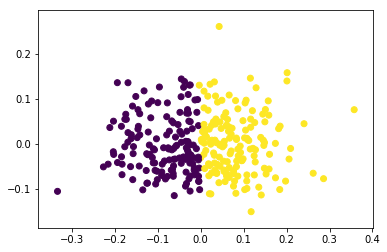

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99


In [86]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Looks like this model isn't doing very well. We're correctly classifying 183 cases, but mis-classifying 120 of the cases!

Now let's try MiniBatch:

In [87]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0        0  154
1      149    0


**We can see that the outcomes are very similar with only 4 mismatch cases, bearing in mind that `MiniBatch` implementation has an additional advantage of being faster than the vanilla `K-means`**

## Drill: More clusters?

Your task is to take the $k$-means code here and see what happens when you change the value of $k$.  What solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor.  Keep in mind that it may be possible to have a solution with more than two clusters that is still better at tracking the real binary outcome – two of those clusters may map to "heart disease" while the other maps to "no heart disease," for example.

## Solution
Here I will increase the clusters from 2 to 10 at step of 1. Any cluster other than 0 will be grouped as 1 in each case so as to maintain the binary clustering of our model.

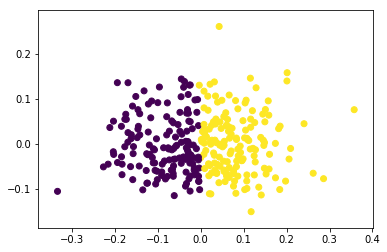

Comparing k-means clusters against the data:


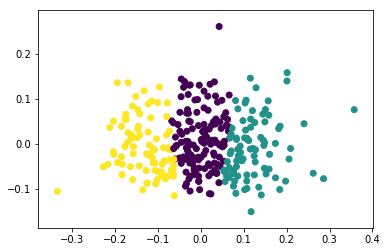

Comparing k-means clusters against the data:


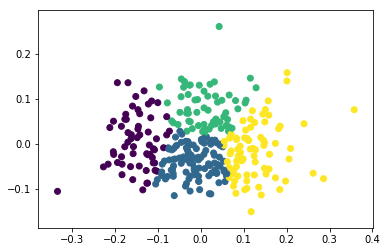

Comparing k-means clusters against the data:


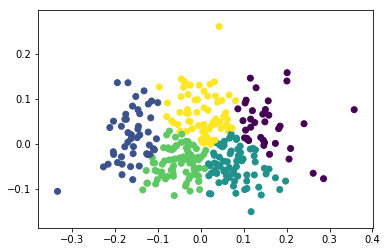

Comparing k-means clusters against the data:


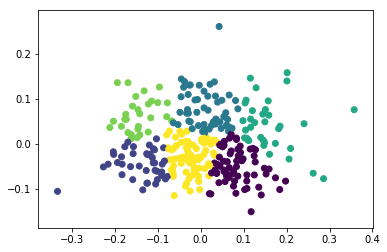

Comparing k-means clusters against the data:


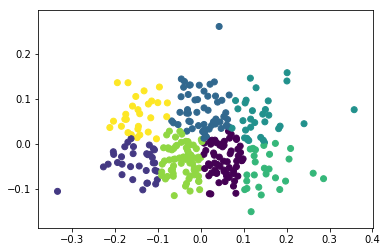

Comparing k-means clusters against the data:


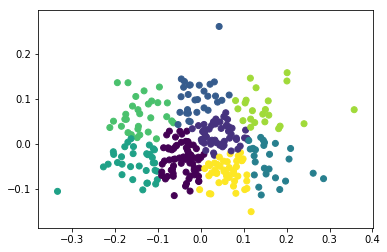

Comparing k-means clusters against the data:


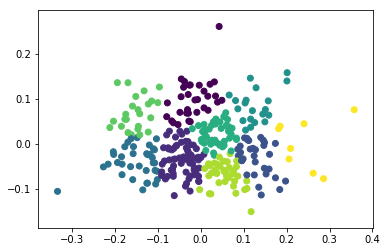

Comparing k-means clusters against the data:


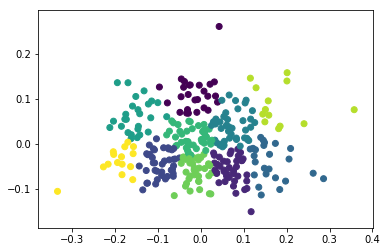

Comparing k-means clusters against the data:
[120, 144, 120, 145, 177, 173, 142, 133, 135]


In [88]:
missed = []
for i in range(2,11,1):
    y_pred = KMeans(n_clusters=i, random_state=42).fit_predict(X_pca)
    # Plot the solution.
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
    plt.show()
    
    print('Comparing k-means clusters against the data:')
    
    #categorize all grop other than '0' as group '1' and generate cross tab
    pred_cat = np.where(y_pred>=1, 1,0)
    cross = pd.crosstab(pred_cat, y)
    
    #calculate the miss-categorized and append to missed
    missed.append((cross[0][1]+cross[1][0]))
    
#print missed for all k-means    
print(missed)

**Here I have ran k-means with k-ranging from 1-10 and outputted the number of missed target. From the array we can see that the best accuracies were obtained with k = 2 and k = 4.**

# Unit4 Lesson2 Project3 – mean-shift, spectral, affinity
Aside from the `k-means` method of clustering, there are a number of other methods available in sklearn. We will consider: `mean-shift`, `spectral` and `affinity` methods here. In this unit we will be using a simulated data which has already been pre-normalised. In real data must first be normalised prior to be used for clustering. This ensures that all the data are given equal weigth when finding a cluster.

## Mean-shift

Mean-shift uses probabilty distribution(the most common being Gausian). First it calculates the probability that a data apoint will be present  at any point in the n-dimensional sapce defind by the number of features( I guess this is why the data points are first plotted and frozen). This probability distribution can be visualized a as surface having hills that `peak` where many data points are present and `flat` areas or valleys where few data point are present. **The `peaks` represent what will become the cluster means.** This surface of probability is called a *kernel dendity surface*.

As an iterative algorithm, in `mean-shift`each data point is shifted `up` towards the closest hill at each iteration, it stays where it's if it has reached the peak or the amount of potential shift is lesser than a specified threshold. The algorithm terminates and assigns clusters once all data point have reached their pick. The process occurs concurently for every datapoint. 

No need to specify how high a hill or low a valley is, this is determined by data density around the hill or valley based on an hyper parameter **`bandwidth`** ranging from 0 to 1 specified by the user. Higher bandwidths create a smoother kernel density surface, leading to fewer peaks because smaller hills are smoothed out, whereas lower bandwidths lead to a surface with more peaks – the same peaks spotted by the higher bandwidth, plus some lower peaks.

Mean shift makes no assumptions about the nature of the data or the `number of clusters`, making it more versatile than $k$-means – though like $k$-means, it creates clusters where data points form an n-dimensional "globe" around a central point.  It works for data sets where many clusters are suspected. Again unlike $k$-means, clusters don't have to be the same size, and can have non-flat geometry, meaning clusters based on $m$ features that cannot be separated by a straight line or plane in the $m$-dimensional space. You may recall the concept of non-flat geometry from the lesson on the kernel trick used by SVM. However, mean shift is slow (runtime increases with the square of the size of the input) so it is recommended for small to medium-sized datasets only.

**Another cool thing about mean shift** is that if a point is too far away from the peaks, it may not be assigned to any cluster at all. This will depend on the threshold and number of iterations allowed. All of the other methods we review here, and $k$-means before, will assign _all_ data points to clusters, no matter how poorly suited to clustering some are.

If you don't know how many clusters you are looking for, or you suspect your clusters are heterogeneous in size or shape, and you're working with a small enough data set, mean-shift may be a good choice.


### Sample data

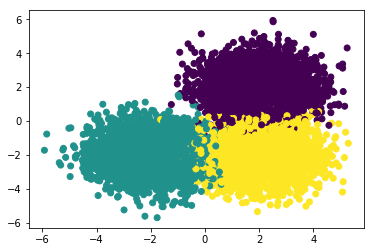

In [89]:
#further reding about make_blob

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

# The coordinates of the centers of our blobs.
#These are the points in the cartesian coordinate where the 3 classes are clustered, we could have simply
#entered center=3 while creating the make_blob object, but with that we'll loose control over the clustering locations.
centers = [[2, 2], [-2, -2], [2, -2]] 

# Make 10,000 rows worth of data with two features representing three
# clusters, each having a standard deviation of 1.
X, y = make_blobs(
    n_samples=10000,
    centers=centers,
    cluster_std=1,
    n_features=2,
    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

In [77]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 3


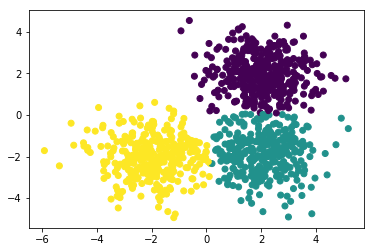

Comparing the assigned categories to the ones in the data:
col_0    0    1    2
row_0               
0      352   10    0
1        1    8  311
2        6  304    8


In [78]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

## Spectral clustering

Unlike ***mean-shift*** which clusters by `probability density` and ***k-means*** which clusters by `mean`, ***spectral clustering*** (and affinity propagation, which we cover next) is based on quantifying similarity between data points – pixels in an image that are nearby or part of the same texture, people in a social network that share a category (friends, family), or words that often appear in the same context would all be types of "similarity" potentially detectable by these algorithms.

Spectral clustering defines a similarity matrix of *n x n* dimensions, where *n* is the number of data points in the dataset.  The matrix is made up of indices of similarity for every pairwise combination of data points. Then, a transformation matrix is applied to calculate a set of eigenvectors with appropriate eigenvalues. In other words, this is PCA on a similarity matrix rather than a covariance matrix.

The spectral clustering algorithm can take many different measures of similarity (also called affinity). Two common ones are "nearest neighbors", which you may recall from the assignment on KNN in the supervised learning lesson, and the Gaussian kernel of the Euclidean distance (called radial basis function or "rbf" in sklearn). We can provide any kernel function that computes pairwise similarity with 0 meaning no similarity and higher numbers indicating greater similarity.

The user provides the number of clusters desired, $k$. The $k$ eigenvectors with the $k$ largest eigenvalues are extracted and the data is converted to the new $k$-dimensional space.  The $k$-means algorithm is then applied to the new $k$-dimensional data to extract $k$ clusters.

Like $k$-means, spectral clustering is slow and works best when $k$ is not too large and clusters are equal in size.  Unlike $k$-means, the dimension reduction aspect of spectral clustering means that it can identify clusters with non-flat geometry, and clusters are not necessarily globular in the original dimensional space.

Let's see this in code

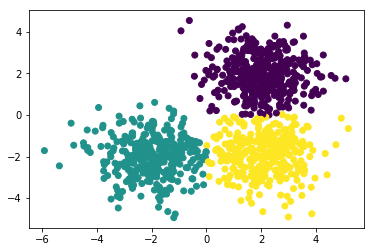

Comparing the assigned categories to the ones in the data:
col_0    0    1    2
row_0               
0      357    0    5
1        1  310    9
2        7    5  306


In [79]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=3

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

Looks good, the two dots at the top though!

## Affinity propagation

Affinity Propagation is based on defining _exemplars_ for data points.  An exemplar is a data point similar enough to another data point that one could conceivably be represented by the other – they convey largely the same information. Affinity Propagation chooses the number of clusters based on the data, and is often used for parsing images. It tends to select more clusters than other methods, making it better suited to data where many clusters are suspected.

Unlike $k$-means, clusters can be uneven in size.  They can also involve non-flat geometry.

Like spectral clustering, affinity propagation begins with an _n x n_ similarity matrix.  Again, any similarity computation can be used.  However, in this case the similarity between points _l_ and _m_ ($s(l,m)$) is interpreted to mean how well-suited data point _l_ is to be an exemplar of  data point _m_ (and vice-versa). Very similar data points would make good exemplars for one another.

Within the similarity matrix, each data point also has a real number $s(l,l)$ indicating that we, the user, would prefer that it be chosen as an exemplar.

In addition, there is a clustering matrix $c$ that is also _n_ by _n_.  Within this matrix, entry $c_{lm}$ is equal to 1 if $m$ is the exemplar of $l$ and 0 otherwise.  Entry $c_{mm}$ will be equal to 1 if _m_ is an exemplar and 0 otherwise.

The goal is to find a matrix composition for _c_ that maximizes the net similarity, measured as the sum of each value of _c_ multiplied by its corresponding value for _s_:

$$\sum_{l=1}^{n}\sum_{m=1}^{n}c_{lm}s(l,m)$$

This is maximized by juggling two parameters.  The first is availability, which is sent from candidate exemplars to potential cluster members to quantify how well-suited that point is to be an exemplar.  The second is responsibility, which is sent from cluster members to exemplars to quantify how well-suited the data point is to be a member of that exemplar's cluster.

The algorithm iterates by using the current availability information to update the responsibility information, and then using the new responsibility information to update the availability information.  It then calculates the net similarity score for the _c_ matrix based on the availability and responsibility information. This iteration algorithm is called the "sum-product algorithm" (because the net similarity score is the sum of products). It has also been called "loopy belief propagation", which is just a fantastic name.

There are two parameters that can be used to "tune" the affinity propagation algorithm to discover more or fewer clusters.  The first, _damping_, causes the responsibility and availability calculations to be weighted by the previous responsibility and
availability options, making changes slower. This helps to avoid a situation where the calculations consistently "overshoot" the best solution.

The second parameter, _preference_, corresponds to $s(l,l)$ and is the user's chance to specify, before the algorithm runs, whether there are certain data points that should be more likely to be chosen as exemplars.  If no values are provided, all preference values are set to the median of the similarity values for all data point pairs.

Affinity propagation is not a quick algorithm.  The time it takes to run each iteration increases with the square of the input data. It's also memory intensive, with memory needs proportional to the square of the input. For this reason, it works best for small and medium datasets, unless you have a lot of time and computational power.

For a deep-dive into the affinity propagation algorithm, [check out this FAQ](http://www.psi.toronto.edu/affinitypropagation/faq.html).

Let's see it in action.

In [82]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))


Done
Estimated number of clusters: 93


Affinity propagation is known to overestimate the number of clusters – in this case, we have an absolutely absurd number.  Let's see what that looks like:

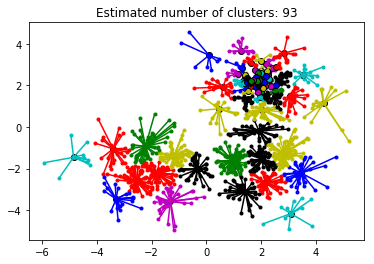

In [83]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

## DRILL: Mo' blobs, mo' problems?

You've seen how these three methods work on three blobs of reasonably separated data. Now go back and change the data. Create more or fewer blobs, and set the blobs closer together or farther apart. Set up at least three different blob configuations, then run the four methods ($k$-means, mean shift, spectral clustering and affinity propagation) on each one.  Write up a report for your mentor where you discuss what you learned about the clustering methods based on their relative performance for your different blob setups. 

# Solution

### Set three different blob config based on cluster number as closeness of there centers

##### Blob config 1: 3 blobs closer together

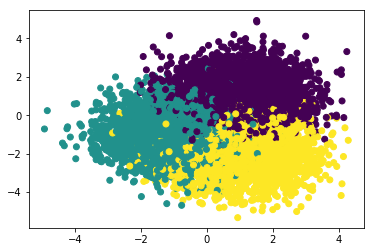

In [118]:
#defining the blob centres, closer coordinates
centers = [[1, 1], [-1, -1], [1, -2]] 

# Make 10,000 rows worth of data with two features representing three
# clusters, each having a standard deviation of 1.
X, y = make_blobs(
    n_samples=10000,
    centers=centers,
    cluster_std=1,
    n_features=2,
    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

**We can see that these clusters are more fused together than the one in the example. Let's now see how perfectly each of `k-means`, `mean shift`, `spectral`, and `affinity` clustering would be able to separate this classes.**

### Applying k-means

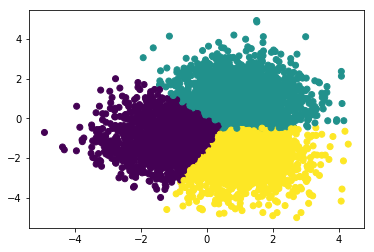

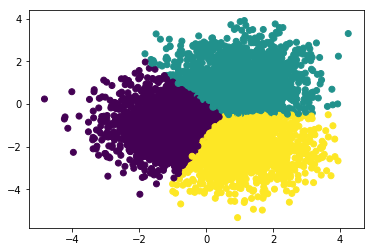

col_0     0     1     2
row_0                  
0       103  1361   219
1      1495   100    94
2        82   192  1354

col_0     0     1     2
row_0                  
0       121  1370   192
1      1441   105    96
2        92   205  1378


In [117]:
#define a k-means object and fit the model, no need to include y-train in the fit
k_means_model = KMeans(n_clusters=3, random_state=42)
k_means_model.fit(X_train)

#first I will predict the training data itself
y_pred_train = k_means_model.predict(X_train)

#then the test data
y_pred_test = k_means_model.predict(X_test)

# Plot the solution.
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred_train)
plt.show()

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test)
plt.show()
    
##print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred_train, y_train))
print()
print(pd.crosstab(y_pred_test, y_test))  


**Seems like there's no point trainning in unsupervised learning**

### Applying mean-shift

In [159]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


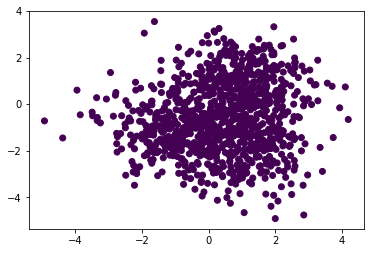

Comparing the assigned categories to the ones in the data:
col_0    0
row_0     
0      362
1      320
2      318


In [160]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

**This model is only able to create one cluster from the training set. It was able to create two clusters(but not accurate) though when I reduced `n_samples` from 500 to 50.**

### Applying Spectral clustering

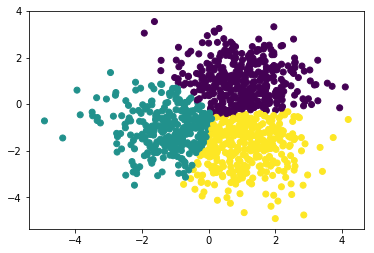

Comparing the assigned categories to the ones in the data:
col_0    0    1    2
row_0               
0      323   13   26
1       29  250   41
2       19   30  269


In [161]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=3

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

**This is close to the rsult obtained from k-means above, still no clea**